# Análise do cubo de dados de Diálises DataSUS

Neste notebook vamos tentar fazer algumas análises simples relacionadas ao cubo de dados gerado para o projeto.

## 1. Setup de Bibliotecas

Vamos primeiramente importar as bibliotecas necessárias e gerar um objeto de conexão com o banco de dados para realizar a análise:

In [2]:
import duckdb
from os import getcwd
from os.path import join as joinpath, realpath, dirname
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

PROJECT_DIR = realpath(joinpath(f"{getcwd()}", '..'))
DATABASE_PATH = realpath(joinpath(PROJECT_DIR, "output_db", "database.db"))

database_connection = duckdb.connect(DATABASE_PATH)

print(database_connection)

## 2. Proporção do tipos de saída

Vamos importar a dimensão de saídas dos tratamentos dialíticos e analisar sua proporção:

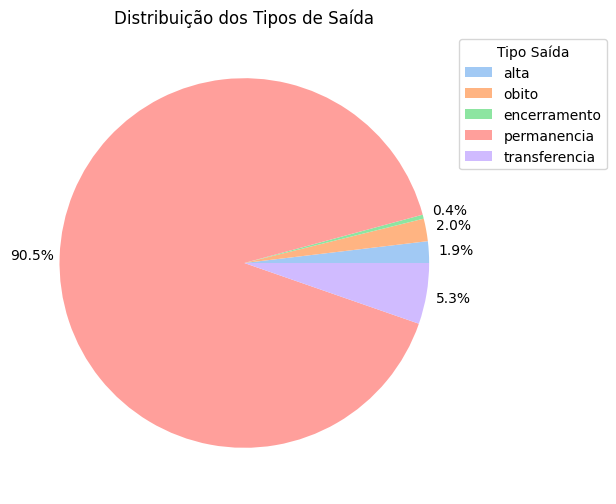

[Text(0, 0, '13254'),
 Text(0, 0, '13847'),
 Text(0, 0, '2487'),
 Text(0, 0, '635393'),
 Text(0, 0, '37422')]

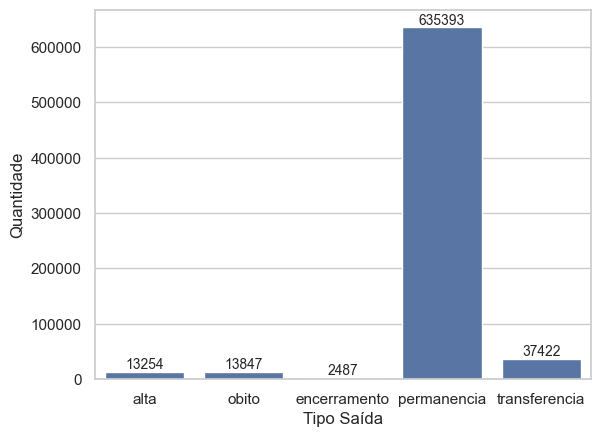

In [3]:
# Definindo a query para obter os dados da tabela Fato_Dialise
get_saidas_query = """
    SELECT 
        ds.*
    FROM main.Fato_Dialise AS fd
    LEFT JOIN main.Dim_Saida AS ds
        ON fd.id_saida = ds.id;
"""
# Obtendo os dados da tabela Fato_Dialise
saidas_df = database_connection.sql(get_saidas_query).df()

# Registrando colunas de interesse
saida_columns = saidas_df.columns.values.tolist()[-5:]

# Contando a quantidade de tipo de saida
saidas_count = [
    sum(saidas_df["alta"].astype(int)), 
    sum(saidas_df["obito"].astype(int)), 
    sum(saidas_df["encerramento"].astype(int)), 
    sum(saidas_df["permanencia"].astype(int)), 
    sum(saidas_df["transferencia"].astype(int))
]

saidas_norm_df = pd.DataFrame({"Tipo Saída": saida_columns, "Quantidade": saidas_count})

# Gerando gráfico com a contagem dos tipos saidas_________________________________________
# Criando o grafico de pizza
plt.figure(figsize=(6, 6))
plt.pie(saidas_count, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=0, 
        rotatelabels=True, 
        colors=sns.color_palette('pastel')[0:5],
        pctdistance=1.15
)
plt.legend(saida_columns, loc="upper right", 
           bbox_to_anchor=(0.8, 0, 0.5, 1), 
           title="Tipo Saída"
)
plt.title("Distribuição dos Tipos de Saída")

# Apresentando o gráfico
plt.show()

# Gerando gráfico de barras com a contagem dos tipos saidas_______________________________
sns.set_theme(style="whitegrid")

ax = sns.barplot(saidas_norm_df, x="Tipo Saída", y="Quantidade", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

## 3.  Analisando invasão municipal

Vamos fazer um sitema de pontuacao onde para cada registro com invasão municipal confirmada, se aumenta 1 ponto para o município do estabelecimento, e se diminui 1 ponto para o município do paciente: 

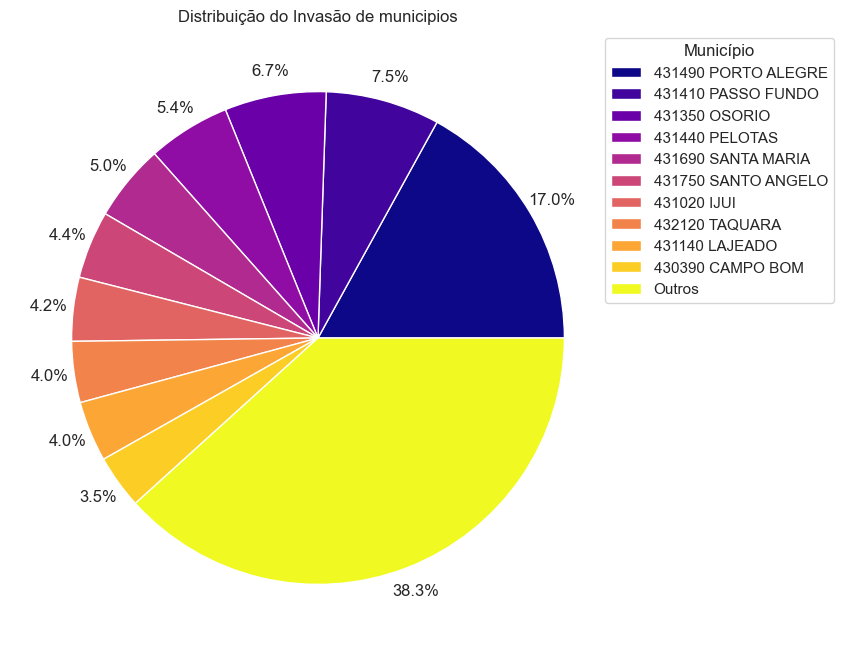

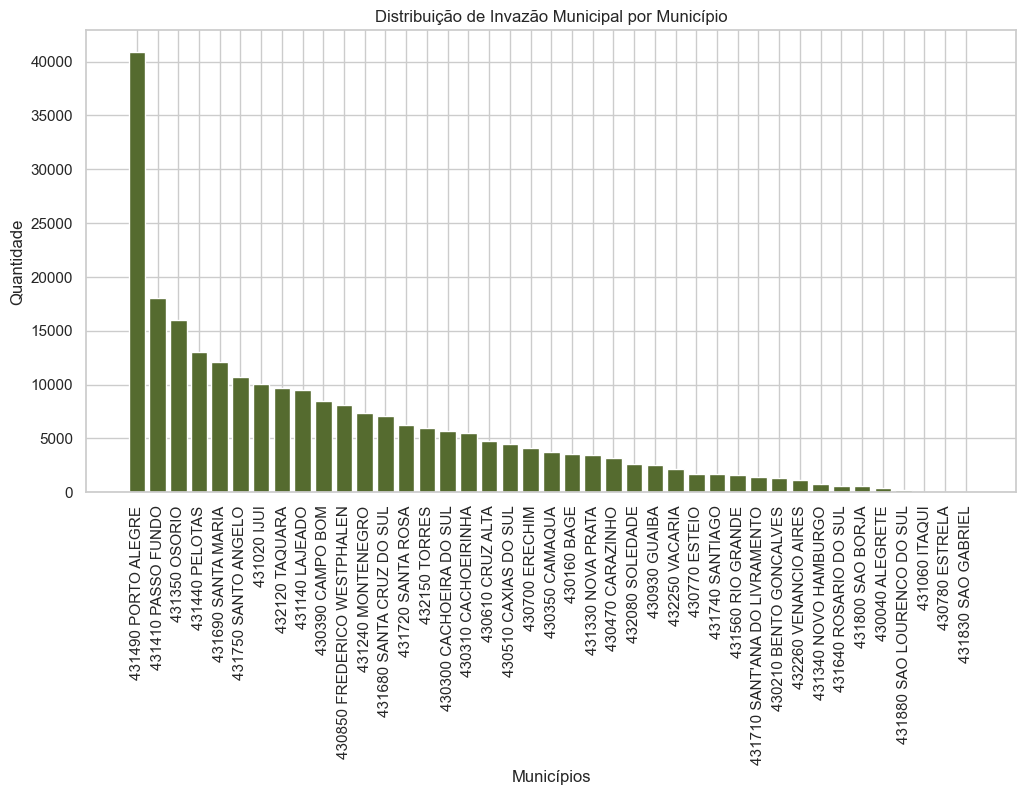

In [4]:
sql_query = """
    WITH add_mun AS (
        SELECT 
            mun_paciente AS mun,
            (COUNT(mun_paciente) * -1) AS value
        FROM main.Fato_Dialise
        WHERE invasao_municipal = TRUE
        GROUP BY mun_paciente
        UNION
        SELECT 
            mun_estabelecimento AS mun,
            COUNT(*) AS value
        FROM main.Fato_Dialise
        WHERE invasao_municipal = TRUE
        GROUP BY mun_estabelecimento
    )
    SELECT dg.municipio, SUM(value) AS value
    FROM add_mun AS ad
    LEFT JOIN main.Dim_Geografia dg
        ON ad.mun = dg.id
    GROUP BY dg.municipio
    ORDER BY value DESC;
"""

invasao_mun_df = database_connection.sql(sql_query).df()

# Gerando um gráfico da proporção de invasão municipal ___________________________________
unsigned_invasao_mun_df = invasao_mun_df[invasao_mun_df["value"] > 0]

top_10_mun_df = unsigned_invasao_mun_df.head(10).copy(deep=True)
others_mun_df = unsigned_invasao_mun_df.iloc[10:].sum(numeric_only=True)

top_10_mun_df.loc[len(top_10_mun_df)] = ["Outros", others_mun_df["value"]]

cmap = plt.get_cmap("plasma")  # You can choose other colormaps like 'plasma', 'inferno', 'magma', etc.
colors = cmap(np.linspace(0, 1, len(top_10_mun_df)))

# Criando o grafico de pizza
plt.figure(figsize=(8, 8))
plt.pie(top_10_mun_df["value"], 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=0, 
        rotatelabels=True, 
        colors=colors,
        pctdistance=1.1
)
plt.legend(top_10_mun_df["municipio"], loc="upper right", 
           bbox_to_anchor=(0.85, 0, 0.5, 1), 
           title="Município"
)
plt.title("Distribuição do Invasão de municipios")

# Apresentando o gráfico
plt.show()

# Gerando gráfico de barras com a proporção de invasão municipal_______________________________________
plt.figure(figsize=(12, 6))
plt.bar(unsigned_invasao_mun_df['municipio'], unsigned_invasao_mun_df['value'], color='darkolivegreen')

# Adicionando rótulos e título
plt.xlabel('Municípios')
plt.ylabel('Quantidade')
plt.title('Distribuição de Invazão Municipal por Município')

# Rotacionando os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Apresentando o gráfico
plt.show()